<a href="https://colab.research.google.com/github/Nyandwi/tf_vision/blob/main/Object_Detection_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with TensorFlow

This is the implementation of Object detection algorithm using Faster RCNN Architectural available in TensorFlow Hub. 

TensorFlow Hub contains ready to use Computer Vision models. 

We will use Faster-RCNN with InceptionResNet V2 as its feature extactor. FasterRCNN is a pupolar object detection model which have shown greater potential in object detection. 

This is the simple architecture of the Faster RCNN. It is casted from the paper. Learn more at its [paper](https://arxiv.org/pdf/1506.01497.pdf). 

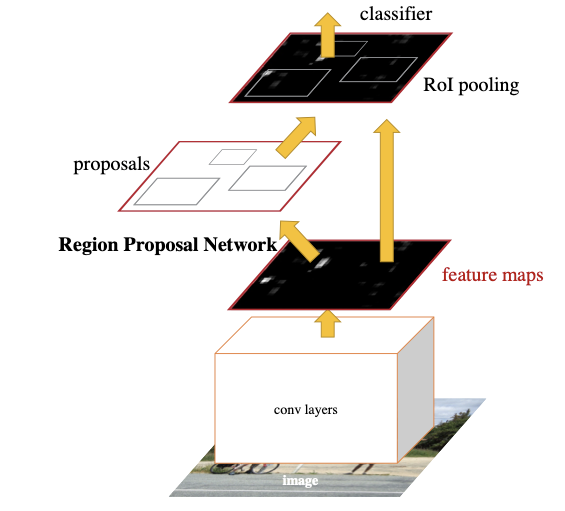

The object detection model was trained on the [Open Image Dataset](https://storage.googleapis.com/openimages/web/index.html)



## Steps to follow in this practice:

* *Importing all relevant libraries*
* *Loading the detection model from the [TensorFlow Hub](https://tfhub.dev)
* *Loading and processing the images to test the detection model*
* *Drawing the bounding box on the image*
* *Running the detector*
* *Applying the detector to the image*



```
Credits:

This project is inspired by the implementation of F-RCNN Paper By TensorFlow availabe at TensorFlow Hub. Part of it are directly used to ensure the detector run smoothly.
```



### 1. Importing all relevant libraries & code base

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
from six import BytesIO
import tempfile
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

## 2. Loading the detection model from the TensorFlow Hub

In [2]:
## Loading the model from the TF Hub

hub_model = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

f_rcnn_model = hub.load(hub_model)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
## Let's choose the model signature

f_rcnn_model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7FE1DA7F5E90>}))

In [4]:
## We will select the default signature

object_detector = f_rcnn_model.signatures['default']

## 3. Loading and processing the images to test the detection model

In this section, we will write functions to download images from a given `url`, process and save it in the Colab workspace. 

In [5]:
def display_image(image):

  """
  #Docstring
  Function to display image

  """

  fig = plt.figure(figsize=(15,10))
  plt.grid(False)
  plt.imshow(image)

In [16]:
def download_process_image(url, width=256, height=256, display=False):

  """
  #Docstring
  Function to download the image specified by `url`, change its width & height to 256 size
  """


  ## Create a temporary file ending with jpg extension
  _, filename = tempfile.mkstemp(suffix='.jpg')

  ## Open the url
  response = urlopen(url)

  ## Reads the image fetched from the url

  image_data = response.read()

  ## Puts the image data in memory buffer

  image_data = BytesIO(image_data)

  ## Opens the image

  pil_image = Image.open(image_data)

  ## Resize the image data 

  pil_image = ImageOps.fit(pil_image, (width, height), Image.ANTIALIAS)


  ## converts to the RGB colorspace
  pil_image_rgb = pil_image.convert("RGB")
    
  ## saves the image to the temporary file created earlier
  pil_image_rgb.save(filename, format="JPEG", quality=90)
    
  print("Image downloaded to %s." % filename)
    
  if display:
    
    display_image(pil_image)

    
  return filename

Image downloaded to /tmp/tmpmog3t4en.jpg.


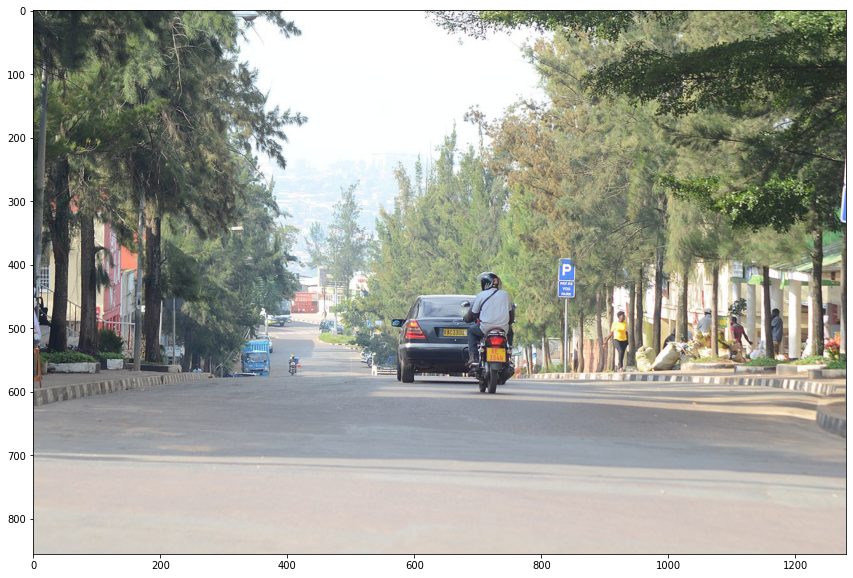

In [17]:
## Load an image from the internet

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Bus_RITCO.jpg/1280px-Bus_RITCO.jpg"
image_url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/A_Kigali.jpg/1280px-A_Kigali.jpg"

download_image_path = download_process_image(image_url2,1280,856,True)

## 4. Drawing the bounding box on the image

Below is a function to draw the bounding box on the image. 



```
Arguments to pass to the function:

        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
```



In [23]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):

    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

## 5. Running the detector

This function will take in the object detection model `object_detector` and the path to the sample image, then use this model to detects the objects. The function `run_detector` will also calls `draw_boes` to draw the predicted bounding boxes. 

In [28]:
def load_img(path):

  # read the file 
  img = tf.io.read_file(path)

  # convert to a tensor
  img = tf.image.decode_jpeg(img, channels=3)

  return img

def run_detector(object_detector, path):

  # load an image tensor from a local file path

  img = load_img(path)

  # add a batch dimension in front of the tensor

  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # run inference using the model

  start_time = time.time()
  result = object_detector (converted_img)
  end_time = time.time()

  # save the results in a dictionary

  result = {key:value.numpy() for key, value in result.items()}

  # print the results

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time:", end_time - start_time)

  # draw the predicted boxes over the image

  image_with_boxes = draw_boxes (
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  # display the image

  display_image(image_with_boxes)

## 6. Applying the detector to the image

For now, let us run the detector on the image we downloaded and processed earlier. 

Found 100 objects.
Inference time: 60.62604284286499


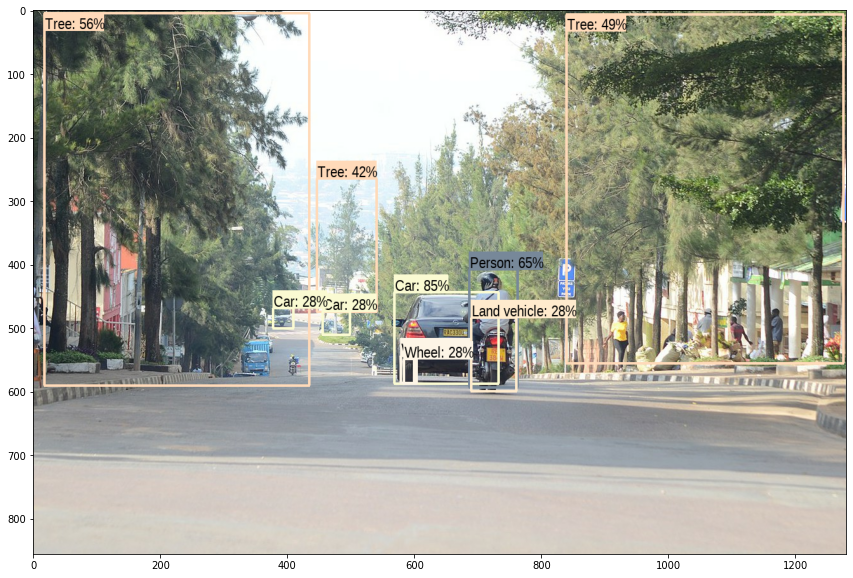

In [29]:
run_detector (object_detector, download_image_path)